<a href="https://colab.research.google.com/github/cristinarainich/Sternberg_analysis/blob/main/Preprocessing_of_datasets_Environmental.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import pylab as pl
import seaborn as sns
import re
from scipy import stats
import scipy.io
import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
from scipy.stats import shapiro
from scipy.stats import normaltest
from scipy.stats import boxcox
%pylab inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Populating the interactive namespace from numpy and matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
sns.set()

In [4]:
!pip install -q pymer4

     |████████████████████████████████| 59 kB 1.8 MB/s 


In [5]:
from pymer4.models import Lmer
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [6]:

!pip install -q statsmodels

In [7]:
# Install R and Rpy2
!apt-get install r-base
!pip install -q rpy2

# Install LMER packages (THIS TAKES ABOUT 3~5 minutes)
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

Reading package lists... Done
Building dependency tree       
Reading state information... Done
r-base is already the newest version (4.2.1-1.1804.0).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.


R[write to console]: Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

R[write to console]: also installing the dependencies ‘minqa’, ‘nloptr’, ‘Rcpp’, ‘RcppEigen’, ‘numDeriv’, ‘estimability’, ‘mvtnorm’, ‘xtable’


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/minqa_1.2.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 53548 bytes (52 KB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =


<rpy2.rinterface_lib.sexp.NULLType object at 0x7f998dc000f0> [RTYPES.NILSXP]

In [8]:
%load_ext rpy2.ipython

In [9]:
%%R 
library(lme4)
library(lmerTest)

R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [10]:
working_path = Path('/content/gdrive/MyDrive/CoganLab/Environmental')

In [11]:
!ls /content/gdrive/MyDrive/CoganLab/Environmental

D64_Block_1_TrialData.mat    eeg_envir.csv		ieeg_envir.csv
D65_Block_1_TrialData_1.mat  Environmental_Subject.mat
D65_Block_1_TrialData.mat    healthy


In [198]:
eeg = pd.read_csv(
    working_path.joinpath('eeg_envir.csv'),
    index_col=None
)
ieeg = pd.read_csv(
    working_path.joinpath('ieeg_envir.csv'),
    index_col=None
)

In [98]:
# checking significance with ttests
def ttest(x, y):
  if len(x) == len(y):
    return stats.ttest_ind(x, y, equal_var = True)
  else:
    return stats.ttest_ind(x, y, equal_var = False)

## iEEG dataset

In [199]:
ieeg.shape

(3464, 28)

In [200]:
ieeg[~ieeg['ProbeType'].isnull()].Subject.unique()

array(['D27'], dtype=object)

In [201]:
ieeg[~ieeg['ProbeType'].isnull()].shape

(160, 28)

In [202]:
ieeg_preprocess = ieeg[ieeg['ProbeType'].isnull()]

In [203]:
ieeg_preprocess.shape

(3304, 28)

In [204]:
ieeg_ = ieeg_preprocess[[
    'block', 'StimlusCategory',
       'ReactionTime', 'Resp', 'RespCorrect',
       'stimulusSounds_idx', 'ProbeCategory', 'probeSound_idx',
       'StimulusCategory', 'Trial',
       'Subject'
]]

For now all the columns contain lists within lists.

In [205]:
block = ieeg_.block.values
new_block = []
for i in block:
  new_block.append(i[10])

In [207]:
stim_cat = ieeg_.StimlusCategory.values
new_stim = []
for i in stim_cat:
  if pd.isna(i) is True:
    new_stim.append(i)
  elif 'environment' in i:
    new_stim.append('environment')
  elif 'nonwords' in i:
    new_stim.append('nonwords')
  elif 'words' in i:
    new_stim.append('words')
  else:
    new_stim.append(i)

In [208]:
stim_cat1 = ieeg_.StimulusCategory.values
new_stim1 = []
for i in stim_cat1:
  if pd.isna(i) is True:
    new_stim1.append(i)
  elif 'environment' in i:
    new_stim1.append('environment')
  elif 'nonwords' in i:
    new_stim1.append('nonwords')
  elif 'words' in i:
    new_stim1.append('words')
  else:
    new_stim1.append(i)

In [209]:
rt = ieeg_.ReactionTime.values
new_rt = []
for i in rt:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']])]]', '')
  new_rt.append(float(new_i))

In [210]:
acc = ieeg_.RespCorrect.values
new_acc = []
for i in acc:
  if '1' in i:
    new_acc.append(1)
  elif '0' in i:
    new_acc.append(0)

In [211]:
resp = ieeg_.Resp.values
new_resp = []
for i in resp:
  if 'None' in i:
    new_resp.append('None')
  elif 'Yes' in i:
    new_resp.append('Yes')
  elif 'No' in i:
    new_resp.append('No')

In [212]:
probe = ieeg_.ProbeCategory.values
new_probe = []
for i in probe:
  if '1' in i:
    new_probe.append(1)
  elif '0' in i:
    new_probe.append(0)

In [213]:
probe_idx = ieeg_.probeSound_idx.values
new_probe_idx = []
for i in probe_idx:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']], dtype=uint8)]]', '')
  new_probe_idx.append(int(new_i))

In [214]:
stim_idx = ieeg_.stimulusSounds_idx.values
new_stim_idx = []
for i in stim_idx:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']], dtype=uint8)]]', '')
  new_stim_idx.append(re.findall(r'\d+', new_i))

Uniting two columns for stimulus category

In [215]:
ieeg_['block'] = new_block
ieeg_['StimlusCategory'] = new_stim
ieeg_['StimulusCategory'] = new_stim1
ieeg_['ReactionTime'] = new_rt
ieeg_['RespCorrect'] = new_acc
ieeg_['Resp'] = new_resp
ieeg_['ProbeCategory'] = new_probe
ieeg_['probeSound_idx'] = new_probe_idx
ieeg_['stimulusSounds_idx'] = new_stim_idx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [216]:
stim1 = ieeg_.StimlusCategory.values
stim2 = ieeg_.StimulusCategory.values

In [217]:
categories = []
for i in range(0, ieeg_.shape[0]):
  if pd.isna(stim1[i]) is True:
    if pd.isna(stim2[i]) is False:
      categories.append(stim2[i])
    else:
      print('Check')
  elif pd.isna(stim1[i]) is False:
    if pd.isna(stim2[i]) is True:
      categories.append(stim1[i])
    else:
      print('Check')  

In [218]:
ieeg_['StimulusCategory'] = categories

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [219]:
ieeg_ = ieeg_.loc[:, ieeg_.columns != 'StimlusCategory']

In [220]:
# checking what are the list lengths for stimuli
length = []
for i in ieeg_.stimulusSounds_idx.values:
  if len(i) not in length:
    length.append(len(i))
print(length)

[3, 7, 9, 5]


In [221]:
length = []
for i in ieeg_.stimulusSounds_idx.values:
  length.append(len(i))
ieeg_['Length'] = length

In [222]:
words = []
nonwords = []
environment = []
for i in ieeg_.StimulusCategory.values:
  if i == 'nonwords':
    words.append(0)
    nonwords.append(1)
    environment.append(0)
  elif i == 'words':
    words.append(1)
    nonwords.append(0)
    environment.append(0)
  elif i == 'environment':
    words.append(0)
    nonwords.append(0)
    environment.append(1)

In [223]:
ieeg_['Words'] = words
ieeg_['Nonwords'] = nonwords
ieeg_['Environment'] = environment

iEEG dataset has 'None' responses in the column 'Resp'. Reaction times corresponding to these trial are identical and either 2500 ms or 4000 ms. This is our No response trials, that we will treat as incorrect in Accuracy analysis and will get rid of them for RT analysis.

In [224]:
ieeg_.groupby(['Subject'])['Trial'].count()

Subject
D28    120
D30    168
D31    168
D32    168
D35    168
D37    168
D38    160
D39    168
D41    168
D42    168
D47    168
D53    168
D54    168
D55    168
D57    168
D63    168
D64    168
D65    168
D69    168
D71    168
Name: Trial, dtype: int64

In [225]:
ieeg_.head()

,block,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,StimulusCategory,Trial,Subject,Length,Words,Nonwords,Environment
160,1,0.990436,No,1,"[3, 7, 15]",0,14,nonwords,0,D28,3,0,1,0
161,1,1.302180,Yes,1,"[16, 7, 14, 13, 9, 11, 6]",1,11,words,1,D28,7,1,0,0
162,1,1.432630,Yes,1,"[17, 15, 13, 5, 9, 10, 7, 6, 1]",1,7,environment,2,D28,9,0,0,1
163,1,1.160734,Yes,1,"[17, 1, 13]",1,13,environment,3,D28,3,0,0,1
164,1,0.845712,Yes,1,"[16, 7, 10, 15, 12, 3, 2]",1,3,environment,4,D28,7,0,0,1


In [226]:
ieeg_ = ieeg_[ieeg_['Subject'] != 'D28']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


216

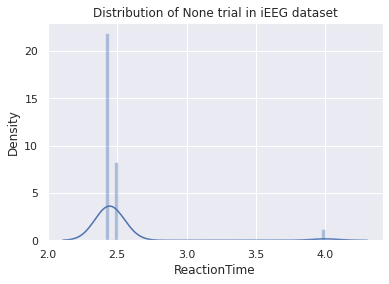

In [228]:
sns.distplot(ieeg_[ieeg_['Resp'] == 'None']['ReactionTime'])
pl.title('Distribution of None trial in iEEG dataset');
ieeg_[ieeg_['Resp'] == 'None']['ReactionTime'].count()

In [229]:
ieeg_[ieeg_['ReactionTime'] > 3.5].Subject.unique()

array(['D30', 'D31'], dtype=object)

In [236]:
idx1 = ieeg_[(ieeg_['Subject'] == 'D30') & (ieeg_['ReactionTime'] > 2.4)].index

In [235]:
idx2 = ieeg_[(ieeg_['Subject'] == 'D31') & (ieeg_['ReactionTime'] > 2.4)].index

In [241]:
ind = []
for i in idx1:
  ind.append(i)
for i in idx2:
  ind.append(i)

In [246]:
ieeg_ = ieeg_.drop(ind)

In [248]:
print(
    'Accuracy without "No response" trials',
    ieeg_[ieeg_['Resp'] != 'None'].RespCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    ieeg_.RespCorrect.mean()
)

Accuracy without "No response" trials 0.8205474822575194
Accuracy with "No response" trials 0.7666561414587938


In [249]:
print('Shape of the dataset with no response trials', ieeg_.shape)
print('Shape of the dataset without no response trials', ieeg_[ieeg_['Resp'] != 'None'].shape)

Shape of the dataset with no response trials (3167, 14)
Shape of the dataset without no response trials (2959, 14)


In [250]:
checkset = ieeg_.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
checkset[checkset['RespCorrect'] < 0.70]

,RespCorrect
Subject,
D37,0.672619
D41,0.428571
D54,0.488095


In [251]:
ieeg_ = ieeg_[
    (ieeg_['Subject'] != 'D37') &
    (ieeg_['Subject'] != 'D41') &
    (ieeg_['Subject'] != 'D54')    
]

In [252]:
print(
    'Accuracy without "No response" trials',
    ieeg_[ieeg_['Resp'] != 'None'].RespCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    ieeg_.RespCorrect.mean()
)

Accuracy without "No response" trials 0.8385719829258829
Accuracy with "No response" trials 0.8114907998497934


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean 1.14655908774156 Max 2.47119832 Min 0.28821655


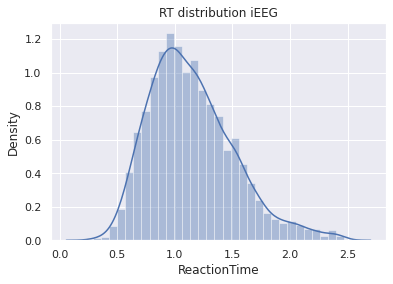

In [253]:
sns.distplot(ieeg_[ieeg_['Resp'] != 'None'].ReactionTime)
pl.title('RT distribution iEEG');
print(
    'Mean', ieeg_[ieeg_['Resp'] != 'None'].ReactionTime.mean(),
    'Max', ieeg_[ieeg_['Resp'] != 'None'].ReactionTime.max(),
    'Min', ieeg_[ieeg_['Resp'] != 'None'].ReactionTime.min()
)

In [254]:
values = []
for i in ieeg_[ieeg_['Resp'] != 'None'].Subject.unique():
  subset = ieeg_[ieeg_['Resp'] != 'None']
  subset = subset[subset['Subject'] == i]
  q75 = np.percentile(subset['ReactionTime'], 75)
  q25 = np.percentile(subset['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset.ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

D30 1
D31 0
D32 0
D35 2
D38 7
D39 3
D42 0
D47 0
D53 1
D55 3
D57 0
D63 0
D69 1
D71 3
D64 0
D65 0


In [255]:
len(values)

21

## EEG dataset

In [133]:
eeg.Subject.unique()

array(['E32', 'E34', 'E35', 'E36', 'E37', 'E38', 'E39', 'E40', 'E41',
       'E42', 'E43', 'E44', 'E45', 'E46'], dtype=object)

In [134]:
eeg.columns

Index(['Unnamed: 0', 'block', 'StimulusCategory', 'ReactionTime', 'KeyCode',
       'Resp', 'RespCorrect', 'stimulusAudioStart', 'stimulusAlignedTrigger',
       'probeAudioStart', 'probeAlignedTrigger', 'stimulusSounds_idx',
       'stimulusSounds_name', 'ProbeCategory', 'probeSound_idx',
       'probeSound_name', 'responseAlignedTrigger', 'trialOrder_All',
       'ListenCueOnset', 'MaintenancePeriodOnset', 'ProbeCueOnset', 'Trial',
       'Subject'],
      dtype='object')

In [135]:
eeg_ = eeg[[
    'block', 'StimulusCategory', 'ReactionTime',
       'Resp', 'RespCorrect', 'stimulusSounds_idx',
       'ProbeCategory', 'probeSound_idx',
       'Trial', 'Subject'
]]

In [136]:
len(eeg.Subject.unique())

14

Getting rid of additional lists containing lists

In [138]:
block = eeg_.block.values
new_block = []
for i in block:
  new_block.append(i[10])

In [150]:
stim_cat = eeg_.StimulusCategory.values
new_stim = []
for i in stim_cat:
  if 'environment' in i:
    new_stim.append('environment')
  elif 'nonwords' in i:
    new_stim.append('nonwords')
  elif 'words' in i:
    new_stim.append('words')

In [143]:
rt = eeg_.ReactionTime.values
new_rt = []
for i in rt:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']])]]', '')
  new_rt.append(float(new_i))

In [144]:
acc = eeg_.RespCorrect.values
new_acc = []
for i in acc:
  if '1' in i:
    new_acc.append(1)
  elif '0' in i:
    new_acc.append(0)

In [145]:
resp = eeg_.Resp.values
new_resp = []
for i in resp:
  if 'None' in i:
    new_resp.append('None')
  elif 'Yes' in i:
    new_resp.append('Yes')
  elif 'No' in i:
    new_resp.append('No')

In [146]:
probe = eeg_.ProbeCategory.values
new_probe = []
for i in probe:
  if '1' in i:
    new_probe.append(1)
  elif '0' in i:
    new_probe.append(0)

In [147]:
probe_idx = eeg_.probeSound_idx.values
new_probe_idx = []
for i in probe_idx:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']], dtype=uint8)]]', '')
  new_probe_idx.append(int(new_i))

In [148]:
stim_idx = eeg_.stimulusSounds_idx.values
new_stim_idx = []
for i in stim_idx:
  new_i = i.replace('[[array([[', '')
  new_i = new_i.replace(']], dtype=uint8)]]', '')
  new_stim_idx.append(re.findall(r'\d+', new_i))

In [151]:
eeg_['block'] = new_block
eeg_['StimulusCategory'] = new_stim
eeg_['ReactionTime'] = new_rt
eeg_['RespCorrect'] = new_acc
eeg_['Resp'] = new_resp
eeg_['ProbeCategory'] = new_probe
eeg_['probeSound_idx'] = new_probe_idx
eeg_['stimulusSounds_idx'] = new_stim_idx

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [153]:
length = []
for i in eeg_.stimulusSounds_idx.values:
  if len(i) not in length:
    length.append(len(i))
print(length)

[3, 7, 9, 5]


In [154]:
length = []
for i in eeg_.stimulusSounds_idx.values:
  length.append(len(i))
eeg_['Length'] = length

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [156]:
words = []
nonwords = []
environment = []
for i in eeg_.StimulusCategory.values:
  if i == 'nonwords':
    words.append(0)
    nonwords.append(1)
    environment.append(0)
  elif i == 'words':
    words.append(1)
    nonwords.append(0)
    environment.append(0)
  elif i == 'environment':
    words.append(0)
    nonwords.append(0)
    environment.append(1)

In [157]:
eeg_['Words'] = words
eeg_['Nonwords'] = nonwords
eeg_['Environment'] = environment

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Preprocessing the data

In [159]:
print(
    'Accuracy without "No response" trials',
    eeg_[eeg_['Resp'] != 'None'].RespCorrect.mean()
)
print(
    'Accuracy with "No response" trials',
    eeg_.RespCorrect.mean()
)

Accuracy without "No response" trials 0.8842105263157894
Accuracy with "No response" trials 0.8703208556149733


In [160]:
print('Shape of the dataset with no response trials', eeg_.shape)
print('Shape of the dataset without no response trials', eeg_[eeg_['Resp'] != 'None'].shape)

Shape of the dataset with no response trials (2992, 14)
Shape of the dataset without no response trials (2945, 14)


In [161]:
eeg_[eeg_['Resp'] == 'None']

,block,StimulusCategory,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,Trial,Subject,Length,Words,Nonwords,Environment
83,4,environment,2.500023,None,0,"[3, 21, 1, 12, 2]",1,2,83,E32,5,0,0,1
124,6,words,2.500035,None,0,"[41, 42, 48, 39, 36, 33, 29]",0,37,124,E32,7,1,0,0
172,8,words,2.500041,None,0,"[28, 30, 46, 31, 32, 45, 34]",1,28,172,E32,7,1,0,0
272,3,words,2.500027,None,0,"[44, 41, 30]",0,33,56,E34,3,1,0,0
317,5,environment,2.500004,None,0,"[14, 3, 7]",1,7,101,E34,3,0,0,1
533,5,environment,2.500035,None,0,"[7, 8, 14, 3, 4, 9, 17]",1,8,101,E35,7,0,0,1
555,6,environment,2.500013,None,0,"[5, 21, 15, 10, 4, 18, 8]",1,21,123,E35,7,0,0,1
571,6,nonwords,2.500020,None,0,"[69, 61, 51, 67, 70, 59, 65]",1,69,139,E35,7,0,1,0
583,7,environment,2.500035,None,0,"[8, 6, 18, 20, 23, 13, 12]",1,18,151,E35,7,0,0,1
588,7,words,2.500002,None,0,"[33, 36, 28, 47, 29, 27, 31, 35, 37]",0,39,156,E35,9,1,0,0


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


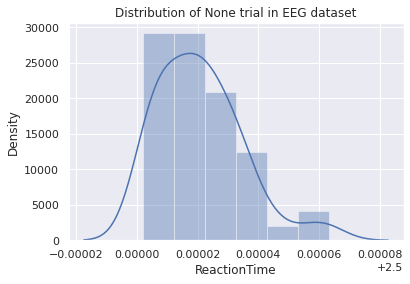

In [163]:
sns.distplot(eeg_[eeg_['Resp'] == 'None']['ReactionTime'])
pl.title('Distribution of None trial in EEG dataset');

In [257]:
checkset = eeg_.groupby(['Subject'])[['RespCorrect']].apply(
    lambda x: x.sum()/x.count()
)
checkset[checkset['RespCorrect'] < 0.70]

,RespCorrect
Subject,


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Mean 0.9929041114329372 Max 2.44919808 Min 0.39225969


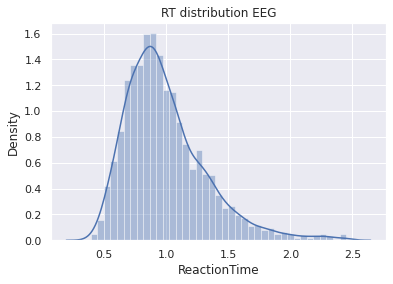

In [256]:
sns.distplot(eeg_[eeg_['Resp'] != 'None'].ReactionTime)
pl.title('RT distribution EEG');
print(
    'Mean', eeg_[eeg_['Resp'] != 'None'].ReactionTime.mean(),
    'Max', eeg_[eeg_['Resp'] != 'None'].ReactionTime.max(),
    'Min', eeg_[eeg_['Resp'] != 'None'].ReactionTime.min()
)

In [258]:
values = []
for i in eeg_[eeg_['Resp'] != 'None'].Subject.unique():
  subset = eeg_[eeg_['Resp'] != 'None']
  subset = subset[subset['Subject'] == i]
  q75 = np.percentile(subset['ReactionTime'], 75)
  q25 = np.percentile(subset['ReactionTime'], 25)
  inter_qr = q75 - q25
  upper = q75 + (inter_qr*3)
  lower = q25 - (inter_qr*3)
  index = 0
  for val in subset.ReactionTime.values:
    if val < lower:
      values.append((i, val))
      index += 1
    elif val > upper:
      values.append((i, val))
      index += 1
  print(i, index)

E32 3
E34 2
E35 4
E36 8
E37 5
E38 3
E39 0
E40 5
E41 2
E42 1
E43 2
E44 1
E45 5
E46 0


In [259]:
len(values)

41

## Accuracy plots. EEG

In [261]:
eeg_.head()

,block,StimulusCategory,ReactionTime,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,Trial,Subject,Length,Words,Nonwords,Environment
0,1,nonwords,1.160933,No,1,"[58, 67, 65]",0,72,0,E32,3,0,1,0
1,1,environment,0.962195,Yes,1,"[23, 15, 9]",1,23,1,E32,3,0,0,1
2,1,words,0.847072,Yes,1,"[31, 46, 48]",1,31,2,E32,3,1,0,0
3,1,nonwords,1.023422,Yes,1,"[62, 55, 51, 59, 64, 67, 70]",1,67,3,E32,7,0,1,0
4,1,nonwords,1.607325,Yes,1,"[56, 68, 69]",1,68,4,E32,3,0,1,0


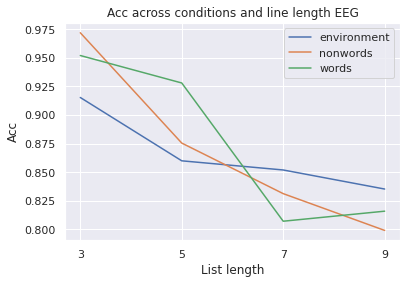

In [264]:
pl.figure()
subset = eeg_.groupby(['StimulusCategory', 'Length'])[['RespCorrect']].mean().reset_index()
for i in subset.StimulusCategory.unique():
  x = subset[subset['StimulusCategory'] == i]
  pl.plot(x.Length, x.RespCorrect)
pl.xticks(x.Length)
pl.xlabel('List length')
pl.ylabel('Acc')
pl.legend(subset.StimulusCategory.unique())
pl.title('Acc across conditions and line length EEG');



In [ ]:
# ONLY MATCH




# ONLY MISMATC

NW vs W
Ttest_indResult(statistic=-0.4284474906807684, pvalue=0.6683716818900234)
NW vs Environment
Ttest_indResult(statistic=0.2554350291355636, pvalue=0.798413506113592)
W vs Environment
Ttest_indResult(statistic=-0.6841461130546627, pvalue=0.4939625083085617)


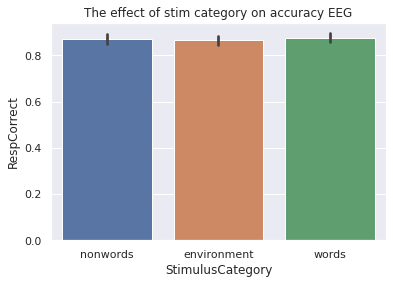

In [ ]:
sns.barplot(x='StimulusCategory', y='RespCorrect', data = eeg_)
pl.title('The effect of stim category on accuracy EEG');
print('NW vs W')
x, y = eeg_[eeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], eeg_[eeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))
print('NW vs Environment')
x, y = eeg_[eeg_['StimulusCategory'] == 'nonwords']['RespCorrect'], eeg_[eeg_['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('W vs Environment')
x, y = eeg_[eeg_['StimulusCategory'] == 'environment']['RespCorrect'], eeg_[eeg_['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=-3.255935675875266, pvalue=0.0011430205875872846)


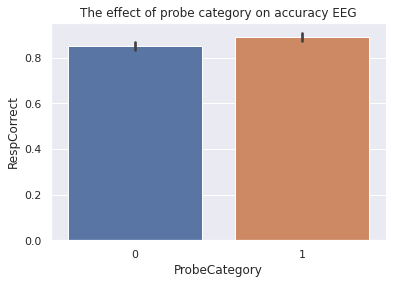

In [ ]:
sns.barplot(x='ProbeCategory', y='RespCorrect', data = eeg_)
pl.title('The effect of probe category on accuracy EEG');
print('0 vs 1')
x, y = eeg_[eeg_['ProbeCategory'] == 0]['RespCorrect'], eeg_[eeg_['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

NW vs W
Ttest_indResult(statistic=1.4175576266968544, pvalue=0.1564786424891116)
NW vs Environment
Ttest_indResult(statistic=0.6911049314570566, pvalue=0.48958161573610814)
W vs Environment
Ttest_indResult(statistic=0.70557677153618, pvalue=0.48053567710421374)


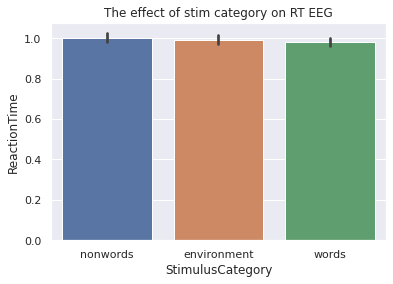

In [ ]:
eeg_no_nones = eeg_[eeg_['Resp'] != 'None']
sns.barplot(x='StimulusCategory', y='ReactionTime', data = eeg_no_nones)
pl.title('The effect of stim category on RT EEG');
print('NW vs W')
x, y = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))
print('NW vs Environment')
x, y = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('W vs Environment')
x, y = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime'], eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=5.467147264673293, pvalue=4.9621422878254886e-08)


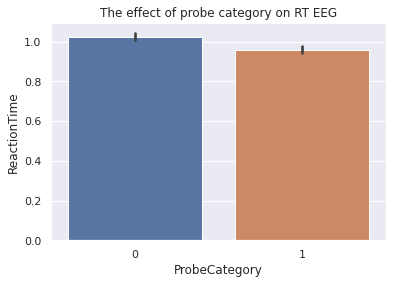

In [ ]:
sns.barplot(x='ProbeCategory', y='ReactionTime', data = eeg_no_nones)
pl.title('The effect of probe category on RT EEG');
print('0 vs 1')
x, y = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 0]['ReactionTime'], eeg_no_nones[eeg_no_nones['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))

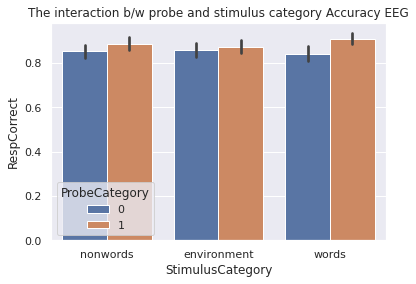

In [ ]:
sns.barplot(x='StimulusCategory', y='RespCorrect', hue='ProbeCategory', data = eeg_)
pl.title('The interaction b/w probe and stimulus category Accuracy EEG');

In [ ]:
print('0 vs 1')
print('Nonwords')
subset = eeg_[eeg_['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Environment')
subset = eeg_[eeg_['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Words')
subset = eeg_[eeg_['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = eeg_[eeg_['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = eeg_[eeg_['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([-1.66955544]), pvalue=array([0.09532619]))
Environment
Ttest_indResult(statistic=array([-0.72983297]), pvalue=array([0.46566446]))
Words
Ttest_indResult(statistic=array([-3.28801405]), pvalue=array([0.00104629]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.43890204]), pvalue=array([0.66082771]))
W vs E Ttest_indResult(statistic=array([-0.70808498]), pvalue=array([0.47905815]))
NW vs E Ttest_indResult(statistic=array([0.26922055]), pvalue=array([0.78781573]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([1.18578064]), pvalue=array([0.23599518]))
W vs E Ttest_indResult(statistic=array([1.85698522]), pvalue=array([0.06361519]))
NW vs E Ttest_indResult(statistic=array([-0.67171276]), pvalue=array([0.50192317]))


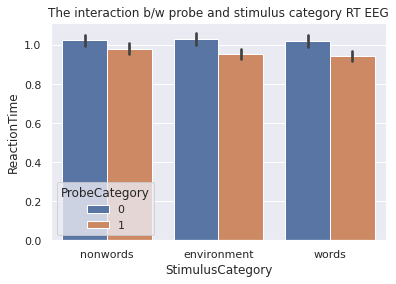

In [ ]:
sns.barplot(x='StimulusCategory', y='ReactionTime', hue='ProbeCategory', data = eeg_no_nones)
pl.title('The interaction b/w probe and stimulus category RT EEG');

In [ ]:
print('0 vs 1')
print('Nonwords')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Environment')
subset = eeg_no_nones[eeg_no_nones['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = eeg_[eeg_['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = eeg_no_nones[eeg_no_nones['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([1.97294624]), pvalue=array([0.04878211]))
Environment
Ttest_indResult(statistic=array([3.51478809]), pvalue=array([0.00046098]))
Words
Ttest_indResult(statistic=array([3.56736019]), pvalue=array([0.00037801]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.0633929]), pvalue=array([0.94946653]))
W vs E Ttest_indResult(statistic=array([-0.31886219]), pvalue=array([0.74989931]))
NW vs E Ttest_indResult(statistic=array([0.25632907]), pvalue=array([0.79775083]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([-2.05449426]), pvalue=array([0.04019606]))
W vs E Ttest_indResult(statistic=array([-0.70738563]), pvalue=array([0.47949644]))
NW vs E Ttest_indResult(statistic=array([-1.33616723]), pvalue=array([0.18180731]))


## Accuracy plots. iEEG

NW vs W
Ttest_indResult(statistic=-1.2996202129993855, pvalue=0.19389319556602957)
NW vs Environment
Ttest_indResult(statistic=1.9949036662863604, pvalue=0.04619876606585375)
W vs Environment
Ttest_indResult(statistic=-3.290177767336641, pvalue=0.0010201678996592895)


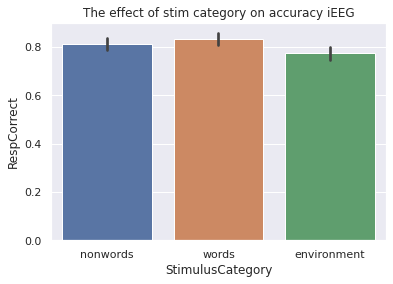

In [ ]:
sns.barplot(x='StimulusCategory', y='RespCorrect', data = ieeg_no_outliers)
pl.title('The effect of stim category on accuracy iEEG');
print('NW vs W')
x, y = ieeg_no_outliers[ieeg_no_outliers['StimulusCategory'] == 'nonwords']['RespCorrect'], ieeg_no_outliers[ieeg_no_outliers['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))
print('NW vs Environment')
x, y = ieeg_no_outliers[ieeg_no_outliers['StimulusCategory'] == 'nonwords']['RespCorrect'], ieeg_no_outliers[ieeg_no_outliers['StimulusCategory'] == 'environment']['RespCorrect']
print(ttest(x,y))
print('W vs Environment')
x, y = ieeg_no_outliers[ieeg_no_outliers['StimulusCategory'] == 'environment']['RespCorrect'], ieeg_no_outliers[ieeg_no_outliers['StimulusCategory'] == 'words']['RespCorrect']
print(ttest(x,y))

NW vs W
Ttest_indResult(statistic=1.0644852224716297, pvalue=0.28725179463135897)
NW vs Environment
Ttest_indResult(statistic=-2.5785949186152948, pvalue=0.010000403169502407)
W vs Environment
Ttest_indResult(statistic=3.6259768882364973, pvalue=0.0002961043804919181)


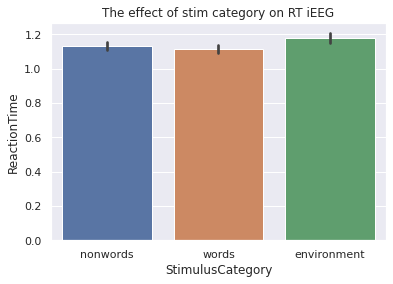

In [ ]:
ieeg_no_nones = ieeg_no_outliers[ieeg_no_outliers['Resp'] != 'None']
sns.barplot(x='StimulusCategory', y='ReactionTime', data = ieeg_no_nones)
pl.title('The effect of stim category on RT iEEG');
print('NW vs W')
x, y = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))
print('NW vs Environment')
x, y = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']['ReactionTime'], ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime']
print(ttest(x,y))
print('W vs Environment')
x, y = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']['ReactionTime'], ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'words']['ReactionTime']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=-5.471638373124856, pvalue=4.865124138212788e-08)


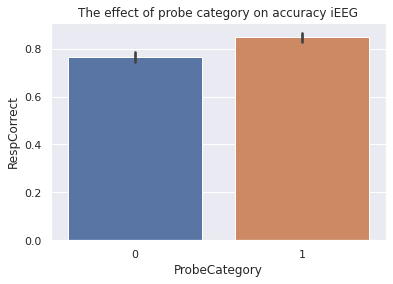

In [ ]:
sns.barplot(x='ProbeCategory', y='RespCorrect', data = ieeg_no_outliers)
pl.title('The effect of probe category on accuracy iEEG');
print('0 vs 1')
x, y = ieeg_no_outliers[ieeg_no_outliers['ProbeCategory'] == 0]['RespCorrect'], ieeg_no_outliers[ieeg_no_outliers['ProbeCategory'] == 1]['RespCorrect']
print(ttest(x,y))

0 vs 1
Ttest_indResult(statistic=3.722077564610176, pvalue=0.00020165552999581963)


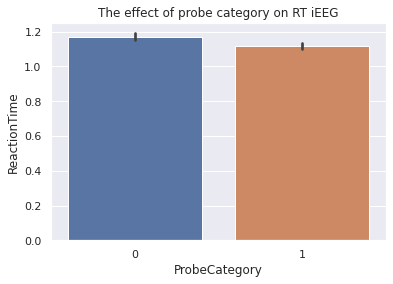

In [ ]:
sns.barplot(x='ProbeCategory', y='ReactionTime', data = ieeg_no_nones)
pl.title('The effect of probe category on RT iEEG');
print('0 vs 1')
x, y = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 0]['ReactionTime'], ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 1]['ReactionTime']
print(ttest(x,y))

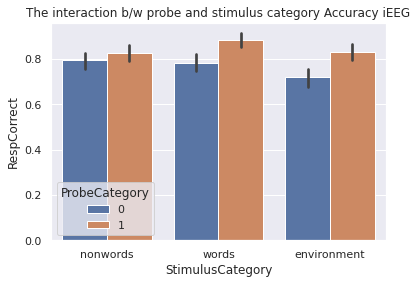

In [ ]:
sns.barplot(x='StimulusCategory', y='RespCorrect', hue='ProbeCategory', data = ieeg_no_outliers)
pl.title('The interaction b/w probe and stimulus category Accuracy iEEG');

In [ ]:
print('0 vs 1')
print('Nonwords')
subset = ieeg_no_outliers[ieeg_no_outliers['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Environment')
subset = ieeg_no_outliers[ieeg_no_outliers['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('Words')
subset = ieeg_no_outliers[ieeg_no_outliers['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['RespCorrect']], subset[subset['ProbeCategory'] == 1][['RespCorrect']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = ieeg_no_outliers[ieeg_no_outliers['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['RespCorrect']], subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['RespCorrect']], subset[subset['StimulusCategory'] == 'nonwords'][['RespCorrect']]
print('NW vs E', ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([-1.24440166]), pvalue=array([0.21366547]))
Environment
Ttest_indResult(statistic=array([-4.10785231]), pvalue=array([4.35434242e-05]))
Words
Ttest_indResult(statistic=array([-4.15906018]), pvalue=array([3.51590302e-05]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.4443887]), pvalue=array([0.65686564]))
W vs E Ttest_indResult(statistic=array([2.30430252]), pvalue=array([0.02142737]))
NW vs E Ttest_indResult(statistic=array([-2.76634278]), pvalue=array([0.00578181]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([2.49678083]), pvalue=array([0.01271048]))
W vs E Ttest_indResult(statistic=array([2.41721629]), pvalue=array([0.01583535]))
NW vs E Ttest_indResult(statistic=array([0.08916582]), pvalue=array([0.9289693]))


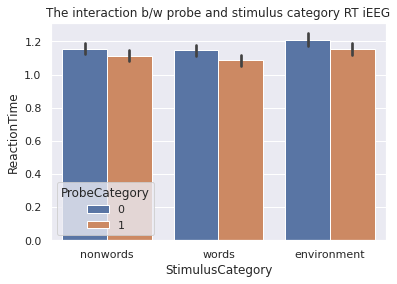

In [ ]:
sns.barplot(x='StimulusCategory', y='ReactionTime', hue='ProbeCategory', data = ieeg_no_nones)
pl.title('The interaction b/w probe and stimulus category RT iEEG');

In [ ]:
print('0 vs 1')
print('Nonwords')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'nonwords']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Environment')
subset = ieeg_no_nones[ieeg_no_nones['StimulusCategory'] == 'environment']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('Words')
subset = eeg_[eeg_['StimulusCategory'] == 'words']
x, y = subset[subset['ProbeCategory'] == 0][['ReactionTime']], subset[subset['ProbeCategory'] == 1][['ReactionTime']]
print(ttest(x,y))
print('')
print('NW vs W vs E')
print('ProbeType 0')
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 0]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

print('ProbeType 1')
subset = ieeg_no_nones[ieeg_no_nones['ProbeCategory'] == 1]
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('W vs NW', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'words'][['ReactionTime']], subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']]
print('W vs E', ttest(x,y))
x, y = subset[subset['StimulusCategory'] == 'environment'][['ReactionTime']], subset[subset['StimulusCategory'] == 'nonwords'][['ReactionTime']]
print('NW vs E', ttest(x,y))

0 vs 1
Nonwords
Ttest_indResult(statistic=array([1.71709694]), pvalue=array([0.0863044]))
Environment
Ttest_indResult(statistic=array([2.18410529]), pvalue=array([0.02921843]))
Words
Ttest_indResult(statistic=array([3.56736019]), pvalue=array([0.00037801]))

NW vs W vs E
ProbeType 0
W vs NW Ttest_indResult(statistic=array([-0.31099129]), pvalue=array([0.75587956]))
W vs E Ttest_indResult(statistic=array([-2.46022411]), pvalue=array([0.01408171]))
NW vs E Ttest_indResult(statistic=array([2.12552768]), pvalue=array([0.03382278]))
ProbeType 1
W vs NW Ttest_indResult(statistic=array([-1.17932342]), pvalue=array([0.23858085]))
W vs E Ttest_indResult(statistic=array([-2.71154045]), pvalue=array([0.00682448]))
NW vs E Ttest_indResult(statistic=array([1.5697685]), pvalue=array([0.11682243]))


## Models iEEG

In [ ]:
ieeg_.head()

,block,ReactionTime,KeyCode,Resp,RespCorrect,stimulusSounds_idx,ProbeCategory,probeSound_idx,StimulusCategory,Trial,Subject
160,1,0.990436,39.0,No,1,3,0,14,nonwords,0,D28
161,1,1.302180,37.0,Yes,1,16,1,11,words,1,D28
162,1,1.432630,37.0,Yes,1,17,1,7,environment,2,D28
163,1,1.160734,37.0,Yes,1,17,1,13,environment,3,D28
164,1,0.845712,37.0,Yes,1,16,1,3,environment,4,D28


Models for accuracy

In [ ]:
%%R -i ieeg_no_outliers
comp1<-lmer('RespCorrect ~ StimulusCategory + ProbeCategory + (1|Subject)', data=ieeg_no_outliers)
comp2<-lmer('RespCorrect ~ StimulusCategory + ProbeCategory + ProbeCategory:StimulusCategory + (1|Subject)', data=ieeg_no_outliers)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    6 2702.103 2737.710 -1345.051 2690.103       NA NA         NA
2    8 2700.341 2747.817 -1342.170 2684.341 5.762053  2 0.05607717


In [ ]:
tryout1 = Lmer(
    'RespCorrect ~ StimulusCategory + ProbeCategory + ProbeCategory:StimulusCategory + (1|Subject)',
    data = ieeg_no_outliers
)
tryout1.fit()

Formula: RespCorrect~StimulusCategory+ProbeCategory+ProbeCategory:StimulusCategory+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2792	 Groups: {'Subject': 17.0}

Log-likelihood: -1360.364 	 AIC: 2720.727

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.032
Residual               0.153  0.391

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.718,0.680,0.757,0.020,173.115,36.528,0.000,***
StimulusCategorynonwords,0.077,0.027,0.127,0.026,2770.049,3.026,0.002,**
StimulusCategorywords,0.065,0.014,0.115,0.026,2773.162,2.518,0.012,*
ProbeCategory,0.111,0.061,0.161,0.026,2770.083,4.362,0.000,***
StimulusCategorynonwords:ProbeCategory,-0.080,-0.150,-0.009,0.036,2770.287,-2.205,0.028,*
StimulusCategorywords:ProbeCategory,-0.010,-0.081,0.061,0.036,2770.277,-0.272,0.785,


Models for RT

In [ ]:
%%R -i ieeg_no_nones
comp1<-lmer('ReactionTime ~ StimulusCategory + ProbeCategory + (1|Subject)', data=ieeg_no_nones)
comp2<-lmer('ReactionTime ~ StimulusCategory + ProbeCategory + ProbeCategory:StimulusCategory + (1|Subject)', data=ieeg_no_nones)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    6 1109.952 1145.329 -548.9761 1097.952        NA NA         NA
2    8 1113.466 1160.635 -548.7328 1097.466 0.4865536  2  0.7840545


In [ ]:
tryout1 = Lmer(
    'ReactionTime ~ StimulusCategory + ProbeCategory + (1|Subject)',
    data = ieeg_no_nones
)
tryout1.fit()

Formula: ReactionTime~StimulusCategory+ProbeCategory+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2687	 Groups: {'Subject': 17.0}

Log-likelihood: -561.405 	 AIC: 1122.809

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.051  0.225
Residual               0.086  0.293

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.213,1.103,1.322,0.056,17.068,21.731,0.0,***
StimulusCategorynonwords,-0.048,-0.075,-0.021,0.014,2667.024,-3.491,0.0,***
StimulusCategorywords,-0.066,-0.094,-0.039,0.014,2667.198,-4.777,0.0,***
ProbeCategory,-0.056,-0.078,-0.034,0.011,2667.027,-4.953,0.0,***


## Models EEG

Models for accuracy

In [ ]:
%%R -i eeg_
comp1<-lmer('RespCorrect ~ ProbeCategory + (1|Subject)', data=eeg_)
comp2<-lmer('RespCorrect ~ ProbeCategory + StimulusCategory + (1|Subject)', data=eeg_)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance     Chisq Df Pr..Chisq.
1    4 1957.469 1981.484 -974.7345 1949.469        NA NA         NA
2    6 1960.989 1997.011 -974.4944 1948.989 0.4801765  2  0.7865585


In [ ]:
tryout1 = Lmer(
    'RespCorrect ~ ProbeCategory + (1|Subject)',
    data = eeg_
)
tryout1.fit()

Formula: RespCorrect~ProbeCategory+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2992	 Groups: {'Subject': 14.0}

Log-likelihood: -982.056 	 AIC: 1964.112

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.001  0.023
Residual               0.112  0.335

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.85,0.829,0.871,0.011,28.461,79.551,0.000,***
ProbeCategory,0.04,0.016,0.064,0.012,2976.919,3.261,0.001,**


Models for RT

In [ ]:
%%R -i eeg_no_nones
comp1<-lmer('ReactionTime ~ ProbeCategory + (1|Subject)', data=eeg_no_nones)
comp2<-lmer('ReactionTime ~ ProbeCategory + StimulusCategory + (1|Subject)', data=eeg_no_nones)
anova(comp1, comp2)

  npar      AIC      BIC    logLik deviance    Chisq Df Pr..Chisq.
1    4 228.8364 252.7879 -110.4182 220.8364       NA NA         NA
2    6 228.9657 264.8929 -108.4829 216.9657 3.870678  2  0.1443753


In [ ]:
tryout1 = Lmer(
    'ReactionTime ~ ProbeCategory + (1|Subject)',
    data = eeg_no_nones
)
tryout1.fit()

Formula: ReactionTime~ProbeCategory+(1|Subject)

Family: gaussian	 Inference: parametric

Number of observations: 2945	 Groups: {'Subject': 14.0}

Log-likelihood: -116.150 	 AIC: 232.299

Random effects:

                 Name    Var    Std
Subject   (Intercept)  0.046  0.214
Residual               0.062  0.248

No random effect correlations specified

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),1.028,0.915,1.141,0.058,13.168,17.841,0.0,***
ProbeCategory,-0.066,-0.084,-0.048,0.009,2930.004,-7.216,0.0,***
